In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# 1. DATA LOADING & PREPROCESSING

def load_and_preprocess_data():
    """
    Loads MNIST dataset and prepares it for:
    - CNN training (images reshaped to 28x28x1)
    - SVM training (flattened to 784 features)
    """
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    x_train_cnn = x_train.reshape(-1, 28, 28, 1)
    x_test_cnn = x_test.reshape(-1, 28, 28, 1)
    x_train_svm = x_train.reshape(-1, 28 * 28)
    x_test_svm = x_test.reshape(-1, 28 * 28)
    return (x_train_cnn, x_train_svm, y_train), (x_test_cnn, x_test_svm, y_test)

In [ ]:
# 2. CNN MODEL
def create_simple_cnn():
    """
    Creates a small CNN architecture for MNIST classification.
    """
    return keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ])


def train_cnn(x_train, y_train, x_test, y_test):
    """
    Trains a CNN and returns the trained model & accuracy.
    """
    model = create_simple_cnn()
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    model.fit(x_train, y_train, epochs=5, batch_size=128,
              validation_data=(x_test, y_test), verbose=1)

    test_accuracy = model.evaluate(x_test, y_test, verbose=0)[1]
    print(f"CNN Test Accuracy: {test_accuracy:.4f}")

    return model, test_accuracy

In [ ]:
# 3. SVM WITH RAW PIXELS
def train_svm_raw_features(x_train, y_train, x_test, y_test):

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    clf = svm.SVC(kernel="rbf", C=1.0, gamma="scale")
    clf.fit(x_train_scaled, y_train)

    y_pred = clf.predict(x_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"SVM (Raw Features) Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    return clf, accuracy, scaler

In [ ]:
#4. CNN FEATURE EXTRACTOR + SVM
def train_cnn_svm(x_train_cnn, y_train, x_test_cnn, y_test):

    # CNN without final softmax for feature extraction
    feature_extractor = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu")
    ])

    full_cnn = keras.Sequential([
        feature_extractor,
        keras.layers.Dense(10, activation="softmax")
    ])

    full_cnn.compile(optimizer="adam",
                     loss="sparse_categorical_crossentropy",
                     metrics=["accuracy"])

    full_cnn.fit(x_train_cnn, y_train, epochs=5, batch_size=128,
                 validation_data=(x_test_cnn, y_test), verbose=1)

    cnn_accuracy = full_cnn.evaluate(x_test_cnn, y_test, verbose=0)[1]
    train_features = feature_extractor.predict(x_train_cnn)
    test_features = feature_extractor.predict(x_test_cnn)
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    test_features_scaled = scaler.transform(test_features)

    clf = svm.SVC(kernel="rbf", C=1.0, gamma="scale")
    clf.fit(train_features_scaled, y_train)

    y_pred = clf.predict(test_features_scaled)
    svm_accuracy = accuracy_score(y_test, y_pred)

    print(f"CNN Feature Extractor + SVM Accuracy: {svm_accuracy:.4f}")
    print(f"Original CNN Accuracy: {cnn_accuracy:.4f}")

    return full_cnn, clf, feature_extractor, scaler, cnn_accuracy, svm_accuracy

In [ ]:
def plot_comparison(results):

    methods = list(results.keys())
    accuracies = list(results.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(methods, accuracies, color=["blue", "green", "red"])
    plt.ylabel("Accuracy")
    plt.title("Comparison of MNIST Classification Approaches")
    plt.ylim(0, 1)

    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                 f"{acc:.4f}", ha="center", va="bottom")

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Loading and preprocessing MNIST data...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1. Training Simple CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8304 - loss: 0.5678 - val_accuracy: 0.9737 - val_loss: 0.0779
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9787 - loss: 0.0713 - val_accuracy: 0.9860 - val_loss: 0.0441
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9862 - loss: 0.0454 - val_accuracy: 0.9894 - val_loss: 0.0364
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9887 - loss: 0.0347 - val_accuracy: 0.9882 - val_loss: 0.0343
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9915 - loss: 0.0276 - val_accuracy: 0.9903 - val_loss: 0.0287
CNN Test Accuracy: 0.9903
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2. Training SVM (Raw Pixels)...
SVM (Raw Features) Test Accuracy: 0.9661

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8144 - loss: 0.5879 - val_accuracy: 0.9785 - val_loss: 0.0723
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9796 - loss: 0.0641 - val_accuracy: 0.9842 - val_loss: 0.0491
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9873 - loss: 0.0436 - val_accuracy: 0.9895 - val_loss: 0.0320
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9899 - loss: 0.0330 - val_accuracy: 0.9882 - val_loss: 0.0334
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9920 - loss: 0.0258 - val_accuracy: 0.9898 - val_loss: 0.0363
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN Feature Extractor + SVM Accuracy: 0.9913
Original CNN Accuracy: 0.9898
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

FINAL RESULTS
CNN: 0.9903
SVM (Raw Features): 0.9661
CNN + SVM: 0.9913
CNN (Original): 0.9898


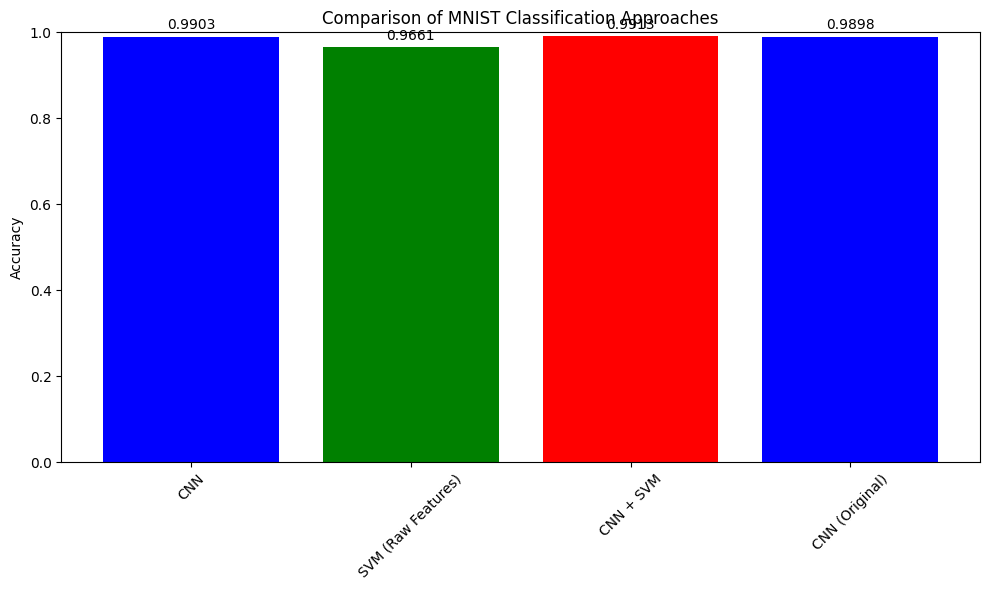


Statistical Comparison Matrix:
                Model  Precision  Recall  F1-score
0                 CNN   0.990338  0.9903  0.990297
1  SVM (Raw Features)   0.966267  0.9661  0.966106
2           CNN + SVM   0.991305  0.9913  0.991296


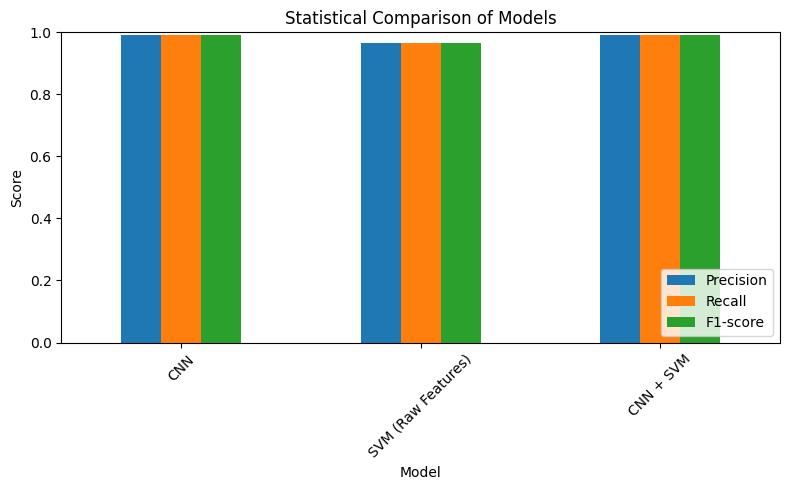

In [ ]:
def plot_statistical_comparison(y_true_dict, y_pred_dict):

    stats_df_list = []

    for model_name in y_pred_dict:
        report = classification_report(
            y_true_dict[model_name],
            y_pred_dict[model_name],
            output_dict=True,
            zero_division=0
        )

        stats_df_list.append(pd.DataFrame({
            "Model": [model_name],
            "Precision": [report["weighted avg"]["precision"]],
            "Recall": [report["weighted avg"]["recall"]],
            "F1-score": [report["weighted avg"]["f1-score"]]
        }))

    final_df = pd.concat(stats_df_list, ignore_index=True)
    print("\nStatistical Comparison Matrix:")
    print(final_df)

    # Plot
    final_df.set_index("Model").plot(kind="bar", figsize=(8, 5))
    plt.ylabel("Score")
    plt.title("Statistical Comparison of Models")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return final_df

def main():
    print("Loading and preprocessing MNIST data...")
    (x_train_cnn, x_train_svm, y_train), (x_test_cnn, x_test_svm, y_test) = load_and_preprocess_data()

    results = {}
    y_true_dict = {}
    y_pred_dict = {}

    print("\n" + "=" * 50)
    print("1. Training Simple CNN...")
    print("=" * 50)
    cnn_model, cnn_acc = train_cnn(x_train_cnn, y_train, x_test_cnn, y_test)
    results["CNN"] = cnn_acc
    y_true_dict["CNN"] = y_test
    y_pred_dict["CNN"] = np.argmax(cnn_model.predict(x_test_cnn), axis=1)

    print("\n" + "=" * 50)
    print("2. Training SVM (Raw Pixels)...")
    print("=" * 50)
    svm_model, svm_acc, svm_scaler = train_svm_raw_features(x_train_svm, y_train, x_test_svm, y_test)
    results["SVM (Raw Features)"] = svm_acc
    y_true_dict["SVM (Raw Features)"] = y_test
    y_pred_dict["SVM (Raw Features)"] = svm_model.predict(svm_scaler.transform(x_test_svm))

    print("\n" + "=" * 50)
    print("3. Training CNN + SVM (Feature Extraction)...")
    print("=" * 50)
    full_cnn, cnn_svm_model, feature_extractor, cnn_svm_scaler, original_cnn_acc, cnn_svm_acc = train_cnn_svm(
        x_train_cnn, y_train, x_test_cnn, y_test)
    results["CNN + SVM"] = cnn_svm_acc
    results["CNN (Original)"] = original_cnn_acc
    y_true_dict["CNN + SVM"] = y_test
    features_test = feature_extractor.predict(x_test_cnn)
    y_pred_dict["CNN + SVM"] = cnn_svm_model.predict(cnn_svm_scaler.transform(features_test))

    print("\n" + "=" * 50)
    print("FINAL RESULTS")
    print("=" * 50)
    for method, acc in results.items():
        print(f"{method}: {acc:.4f}")

    plot_comparison(results)
    plot_statistical_comparison(y_true_dict, y_pred_dict)

    return {
        "cnn_model": cnn_model,
        "svm_model": svm_model,
        "full_cnn": full_cnn,
        "feature_extractor": feature_extractor,
        "results": results
    }


if __name__ == "__main__":
    main()